In [9]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image

In [10]:
# Define the CNN-based policy network
class CNNGymPolicy(nn.Module):
    def __init__(self, input_channels, n_actions):
        super(CNNGymPolicy, self).__init__()
        self.input_channels = input_channels
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        # Update the linear layer according to the flattened size of the conv3 output
        self.fc = nn.Linear(self._calculate_conv_output_size(), 512)
        self.out = nn.Linear(512, n_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return F.softmax(self.out(x), dim=1)

    def _calculate_conv_output_size(self):
        # Use a dummy input to calculate the output size after the conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.input_channels, 84, 84)  # Assuming the input size 84x84
            dummy_output = self.conv3(self.conv2(self.conv1(dummy_input)))
            return int(torch.prod(torch.tensor(dummy_output.size()[1:])))

In [11]:
env = gym.make('MsPacman-v4', render_mode="rgb_array")
num_actions = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
# Initialize the policy
policy = CNNGymPolicy(input_channels=3, n_actions=num_actions).to(device)
# Set up the optimizer
optimizer = optim.Adam(policy.parameters(), lr=0.0001)

In [13]:
import numpy as np

def preprocess_state(state):
    # Check if the state is already a numpy array (image)
    if isinstance(state, np.ndarray):
        pass
    elif isinstance(state, tuple) or isinstance(state, list):
        state = state[0]
    else:
        raise TypeError("Unsupported state format")

    # Apply the image preprocessing transformations
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((84, 84)),  # Resize to a smaller, more manageable size
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(state).unsqueeze(0)


In [15]:
#policy is an instance of CNNGymPolicy and optimizer is set up

import numpy as np


def compute_returns(rewards, gamma=0.99):
    """Compute the discounted returns for each time step"""
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return returns

cum_avg_rewards = []
scores = []
last_10_episode_rewards = []  # List to store rewards of the last 10 episodes
rolling_avg_last_10 = []  # List to store the rolling average

total_rewards = 0  # Variable to store the total rewards across episodes
cumulative_average = 0  # Variable to store the cumulative average of total rewards

batch_size = 5  # Number of episodes per batch
batch_rewards = []
batch_returns = []
batch_log_probs = []
total_rewards = 0

num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_rewards = []
    episode_log_probs = []

    while not done:
        state_tensor = preprocess_state(state).to(device)
        action_probs = policy(state_tensor)
        action = torch.multinomial(action_probs, 1).item()
        log_prob = torch.log(action_probs.squeeze(0)[action])

        next_state, reward, done, info, _ = env.step(action)
        episode_rewards.append(reward)
        episode_log_probs.append(log_prob)
        state = next_state

    # Compute returns for the episode and add to batch
    episode_returns = compute_returns(episode_rewards)
    batch_rewards.extend(episode_rewards)
    batch_returns.extend(episode_returns)
    batch_log_probs.extend(episode_log_probs)

    # Update policy after collecting data for the batch
    if (episode + 1) % batch_size == 0 or episode == num_episodes - 1:
        # Calculate the baseline (average return of the batch)
        baseline = sum(batch_returns) / len(batch_returns)

        # Policy gradient update with baseline
        policy_loss = []
        for log_prob, Gt in zip(batch_log_probs, batch_returns):
            adjusted_return = Gt - baseline
            policy_loss.append(-log_prob * adjusted_return)

        policy_loss = torch.cat([loss.unsqueeze(0) for loss in policy_loss]).sum()
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Clear the batch data
        batch_rewards = []
        batch_returns = []
        batch_log_probs = []

    # Calculate and store episode statistics
    episode_total_reward = sum(episode_rewards)
    total_rewards += episode_total_reward
    cumulative_average = total_rewards / (episode + 1)
    cum_avg_rewards.extend([cumulative_average])

    last_10_episode_rewards.append(episode_total_reward)
    if len(last_10_episode_rewards) > 10:
        last_10_episode_rewards.pop(0)
    
    avg_last_10 = sum(last_10_episode_rewards) / len(last_10_episode_rewards)
    rolling_avg_last_10.append(avg_last_10)

    print(f"Episode {episode + 1}/{num_episodes}, Episode Reward: {episode_total_reward}, "
          f"Cumulative Average: {cumulative_average}, Average of Last 10: {avg_last_10}")


# Close the environment when done
env.close()

Episode 1/1000, Episode Reward: 140.0, Cumulative Average: 140.0, Average of Last 10: 140.0
Episode 2/1000, Episode Reward: 180.0, Cumulative Average: 160.0, Average of Last 10: 160.0
Episode 3/1000, Episode Reward: 300.0, Cumulative Average: 206.66666666666666, Average of Last 10: 206.66666666666666
Episode 4/1000, Episode Reward: 150.0, Cumulative Average: 192.5, Average of Last 10: 192.5
Episode 5/1000, Episode Reward: 290.0, Cumulative Average: 212.0, Average of Last 10: 212.0
Episode 6/1000, Episode Reward: 180.0, Cumulative Average: 206.66666666666666, Average of Last 10: 206.66666666666666
Episode 7/1000, Episode Reward: 100.0, Cumulative Average: 191.42857142857142, Average of Last 10: 191.42857142857142
Episode 8/1000, Episode Reward: 190.0, Cumulative Average: 191.25, Average of Last 10: 191.25
Episode 9/1000, Episode Reward: 330.0, Cumulative Average: 206.66666666666666, Average of Last 10: 206.66666666666666
Episode 10/1000, Episode Reward: 280.0, Cumulative Average: 214.0,

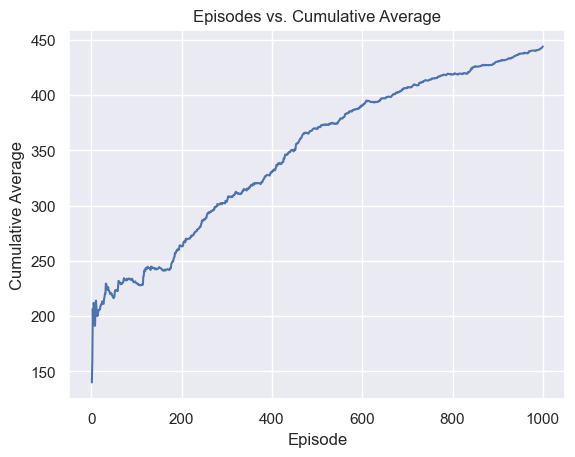

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# episode_scores and cum_avg_rewards are lists containing the scores and cumulative averages

# Create a DataFrame for the data
data = {'Episode': range(1, len(cum_avg_rewards) + 1), 'Cumulative_Average': cum_avg_rewards}
df = pd.DataFrame(data)

# Create the seaborn plot
sns.set()
sns.lineplot(x='Episode', y='Cumulative_Average', data=df)
plt.title('Episodes vs. Cumulative Average')
plt.xlabel('Episode')
plt.ylabel('Cumulative Average')
plt.show()

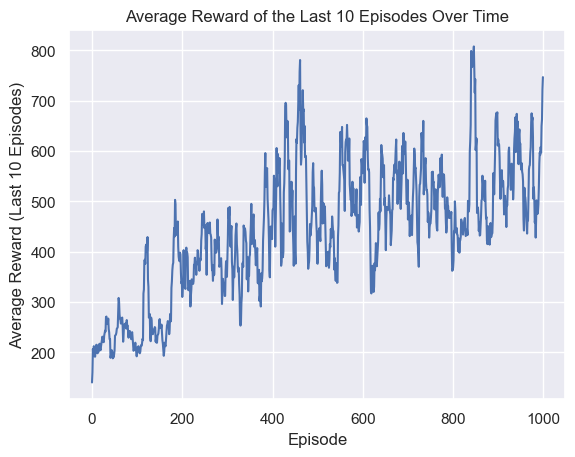

In [21]:
import matplotlib.pyplot as plt

# Plotting the average of the last 10 episode rewards
plt.plot(rolling_avg_last_10)
plt.title('Average Reward of the Last 10 Episodes Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward (Last 10 Episodes)')
plt.show()
